In [1]:
#%cd $HOME/projects/where_does_icl_happen
%cd ..

/home/ssia/projects/where_does_in-context-learning_happen_in_LLMs


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex

import json
import seaborn
sns.set_style('whitegrid')

from omegaconf import OmegaConf
import pandas as pd
import numpy as np
import argparse
import os

rd = lambda x: np.around(x, 2)

### Load Default args for `exp = mask_context_from`

In [13]:
exp = "mask_context_from"

baseline_cfp = OmegaConf.load(f'configs/file_paths/default.yaml')
cfp = OmegaConf.load(f"configs/file_paths/{exp}.yaml")
model_cf = OmegaConf.load(f'configs/model/masks/{exp}_TTT.yaml')
data_cf = OmegaConf.load('configs/data/default.yaml')
format_cf = OmegaConf.load('configs/format/instr_none_QA.yaml')
generator_cf = OmegaConf.load('configs/generator/default.yaml')
training_cf = OmegaConf.load('configs/training/default.yaml')
prompt_cf = OmegaConf.load('configs/prompt_select/random.yaml')

args = OmegaConf.merge(model_cf, data_cf, format_cf, generator_cf, training_cf, prompt_cf, baseline_cfp)
args.seed = 0
args.sample_prompts.nprompts = nprompts = 5

#### Load specific args for exp = mask_context_from

In [46]:
# en-fr settings
#models = ["llama7b", "llama7b-chat"]
#models = ['gptn2.7B', 'bloom3b']
#models = ['bloom3b', 'bloom3b']
models = ['gptn125M', 'gptn125M']

domain = "translation" #"code_gen" # "translation"

if domain == "code_gen":
    instrs = ['instr_code_gen', 'instr_none_QA']
    args.data.trainset = "MBPP"
    args.data.testset = "HEVAL"
    args.data.direction = "en-py"
    conditions = [ ('instr_none_QA', 5, False, True), ("instr_code_gen", 5, True, True),("instr_code_gen", 5, False, True)]
    y='pass@1'
else:
    args.data.trainset = "FLORES"
    args.data.testset = "FLORES"
    args.data.direction = "fr-en"
    conditions = [("instr_none_QA", nprompts, False, True, False), 
                  ("instr_machine_translation", nprompts, True, True, False),
                  ("instr_machine_translation", nprompts, True, True, True),
                  ("instr_machine_translation", nprompts, False, True, False)]
    y='bleu'

# code_gen settings
#models = ['starcoder2-3B', 'starcoder2-7B']
#models = ['llama7b', 'llama7b-chat']


### Load data into the DataFrame for Plotting|

In [51]:
model_layers = {"gptn125M":12,
                "gptn2.7B":32, 
                "bloom3b":30, 
                "llama7b": 32, 
                "llama7b-chat":32, 
                "starcoder2-3B":32, 
                "starcoder2-7B":32}

name_dict = {'instr_none_QA_Instructions-False-maskPrompts-True': r"$\overline{Ex}^{Mask}Query$",
            'instr_machine_translation_Instructions-True-maskPrompts-True':r"$\overline{Instr, Ex}^{Mask}Query$",
            'maskQuery':r"$\overline{Instr, Ex, Query}^{Mask}$",
            'instr_machine_translation_Instructions-False-maskPrompts-True':r"$Instr, \overline{Ex}^{Mask}Query$",
            'instr_code_gen_Instructions-True-maskPrompts-True':r"$\overline{Instr, Ex}^{Mask}Query$",
            'instr_code_gen_Instructions-False-maskPrompts-True':r"$Instr, \overline{Ex}^{Mask}Query$"
            }

def get_df(cfp, args):
    df = []
    nlayers = model_layers[args.model.model_size]

    if args.model.causal_mask.query:
        name = "maskQuery"
        print("name:", name)
    else:
        name = f"{args.format.name}_Instructions-{args.model.causal_mask.instructions}-maskPrompts-{args.model.causal_mask.prompts}" 

    for j in range(nlayers):
        for s in range(5):
            
            args.model.mask_layer = j
            args.seed = s
            fn = cfp['res_fn'].format(**args) + ".temp"
            if not os.path.exists(fn):
           #     print(fn)
                continue
                
            with open(fn, 'r') as f:
                data = json.load(f)

                if type(data) == list:
                    data = data[0]

            data_ = {"layer": j+1, "seed": s, "model": args.model.model_size, 'name': name_dict[name]}
            data.update(data_)
            df.append(data)
                
    df = pd.DataFrame(df)
    return df 


In [52]:
all_df = []
i = 0
for model in models:
    for (instr, nprompt, mask_instr, mask_ex, mask_query) in conditions:
        args.format.name = instr
        args.model.model_size = model
        args.sample_prompts.nprompts = nprompt
        args.model.causal_mask.instructions = mask_instr
        args.model.causal_mask.query = mask_query
        args.model.causal_mask.prompts = mask_ex
        df = get_df(cfp, args)
        all_df.append(df)
            
all_df = pd.DataFrame(pd.concat(all_df))
all_df = all_df.drop_duplicates()
print(len(all_df))

name: maskQuery
name: maskQuery
64


### Preparing to plot

In [53]:
ls "results/mask_context_from/instructions-False_prompts-True/layer-0/format-instr_none_QA/no_lengthfilter-random/gen-defaultsentence/FLORES-FLORES/gptn125M-nprompts1-seed0.fr-en.json.refac.temp"

ls: cannot access 'results/mask_context_from/instructions-False_prompts-True/layer-0/format-instr_none_QA/no_lengthfilter-random/gen-defaultsentence/FLORES-FLORES/gptn125M-nprompts1-seed0.fr-en.json.refac.temp': No such file or directory


In [54]:
models = ['gptn125M', 'gptn125M']
task = "machine_translation"
def get_baseline(args, models):
    base_scores = {}

    for model in models:
        for args.seed in range(5):
            args.model.model_size = model
            args.format.name = f"instr_{task}"
            fn = args['res_fn_baseline'].format(**args) + ".temp"
            if not os.path.exists(fn):
                print(fn)
                continue
                
            with open(fn, 'rb') as f:
                data = json.load(f)
            if type(data) == list:
                data = data[0]
                
            base_scores[model] = {}
            base_scores[model][args.data.direction] = base_scores[model].get(args.data.direction, []) + [data[y]]
    return base_scores

base_scores = get_baseline(args, models)
print(base_scores)

results/baselines/format-instr_machine_translation/no_lengthfilter-random/gen-defaultsentence/FLORES-FLORES/gptn125M-nprompts5-seed3.fr-en.json.temp
results/baselines/format-instr_machine_translation/no_lengthfilter-random/gen-defaultsentence/FLORES-FLORES/gptn125M-nprompts5-seed4.fr-en.json.temp
results/baselines/format-instr_machine_translation/no_lengthfilter-random/gen-defaultsentence/FLORES-FLORES/gptn125M-nprompts5-seed3.fr-en.json.temp
results/baselines/format-instr_machine_translation/no_lengthfilter-random/gen-defaultsentence/FLORES-FLORES/gptn125M-nprompts5-seed4.fr-en.json.temp
{'gptn125M': {'fr-en': [1.563]}}


0 gptn125M


/home/ssia/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ssia/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


1 gptn125M


/home/ssia/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ssia/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


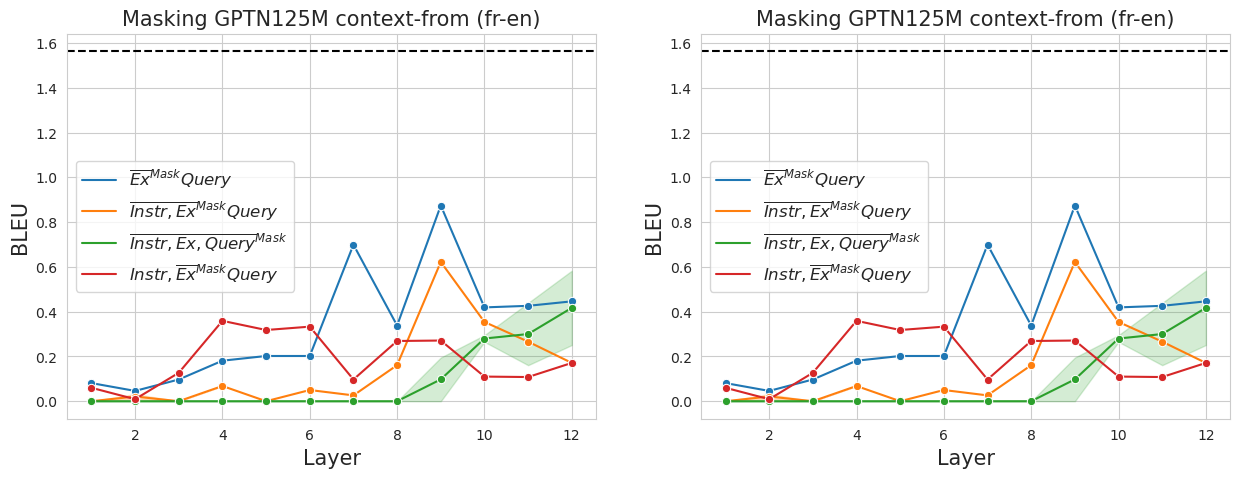

In [55]:
figs, axs = plt.subplots(1,len(models), figsize=(15, 5))

for i, model in enumerate(models):
    print(i, model)
    sns.lineplot(ax=axs[i], data=all_df[all_df['model']==model], x="layer", y=y, hue="name", marker="o")
    axs[i].axhline(y=np.mean(base_scores[model][args.data.direction]), color='black', linestyle="--")

    axs[i].set_ylabel(y.upper(), fontsize=15)
    axs[i].set_xlabel('Layer', fontsize=15)
    axs[i].set_title(f"Masking {model.upper()} context-from ({args.data.direction})", fontsize=15)
    axs[i].legend(fontsize=12)

plt.show()